# Blind Separation method project (using the FastICA algorithm that is built from scratch)
# By Youssef Bounou

# Import Libraries and Define Functions

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from scipy.stats import pearsonr

# Function to read binary data from the .rec file after the metadata
def read_binary_data(file_path, offset):
    with open(file_path, 'rb') as file:
        file.seek(offset)
        binary_data = file.read()
    return binary_data

# Function to read the initial lines of text from the file to get metadata
def read_initial_text(file_path, num_bytes=500):
    with open(file_path, 'rb') as file:
        text_content = file.read(num_bytes).decode('ascii', errors='ignore')
    return text_content

# FastICA implementation from scratch
def fastica(X, num_components, max_iter=200, tol=1e-4):
    def _sym_decorrelation(W):
        """ Symmetric decorrelation """
        K = np.dot(W, W.T)
        s, u = np.linalg.eigh(K)
        return np.dot(np.dot(u * (1.0 / np.sqrt(s)), u.T), W)
    
    def _g(x):
        """ 'tanh' nonlinearity and its derivative """
        return np.tanh(x), 1 - np.square(np.tanh(x))
    
    X = X.T  # Transpose the data to match the dimensions
    num_samples, num_features = X.shape
    
    # Center the data
    X -= X.mean(axis=1, keepdims=True)
    
    # Initialize the mixing matrix with random values
    W = np.random.rand(num_components, num_components)
    
    # Symmetric decorrelation
    W = _sym_decorrelation(W)
    
    for _ in range(max_iter):
        W_old = W.copy()
        
        # Projected data
        X_projected = np.dot(W, X)
        
        # Non-linear function and its derivative
        g_X, g_prime_X = _g(X_projected)
        
        # Update rule for W
        W = np.dot(g_X, X.T) / num_samples - np.diag(g_prime_X.mean(axis=1)).dot(W)
        
        # Symmetric decorrelation
        W = _sym_decorrelation(W)
        
        # Check for convergence
        if np.max(np.abs(np.abs(np.diag(np.dot(W, W_old.T))) - 1)) < tol:
            break
    
    # Calculate the separated signals
    S = np.dot(W, X)
    return S.T


# Read Data and Preprocess Signals

In [2]:
# Define the file path for the .rec file
file_path = './sleepDataset/sc4002e0.rec'

# Read and display the initial text lines for metadata
initial_text = read_initial_text(file_path, num_bytes=500)
print("Initial Metadata:")
print(initial_text)

# Set assumed parameters
num_channels = 7  # Based on initial text
sample_rate = 256  # Example sampling rate in Hz

# Estimate the offset where binary data begins (after the text metadata)
offset = 500
binary_data = read_binary_data(file_path, offset)

# Calculate the total number of samples
total_samples = len(binary_data) // (2 * num_channels)  # 2 bytes per int16

# Function to convert binary data to signals
def binary_to_signals(binary_data, num_channels, total_samples):
    # Convert binary data to numpy array
    signals = np.frombuffer(binary_data, dtype=np.int16)
    # Reshape based on the number of channels
    signals = signals[:total_samples * num_channels].reshape((total_samples, num_channels))
    return signals

# Convert binary data to signals
signals = binary_to_signals(binary_data, num_channels, total_samples)

# Channel names and descriptions based on text metadata
channel_info = {
    'EEG Fpz-Cz': 'Électroencéphalogramme frontal-pôle central : Activité électrique du cerveau entre Fpz et Cz.',
    'EEG Pz-Oz': 'Électroencéphalogramme pôle central-occipital : Activité électrique du cerveau entre Pz et Oz.',
    'EOG horizontal': 'Électrooculogramme horizontal : Mouvements horizontaux des yeux.',
    'Resp oro-nasal': 'Respiration oronasale : Flux respiratoire par le nez et la bouche.',
    'EMG Submental': 'Électromyogramme submental : Activité musculaire sous le menton.',
    'Temp body': 'Température corporelle : Mesure de la température du corps.',
    'Event marker': 'Marqueur d\'événements : Indicateurs d\'événements spécifiques.'
}


Initial Metadata:
0       X F X X Age 33                                                                  Startdate 25-APR-1989 X X Polyman                                               25.04.8914.50.002048                                                1415    60      7   EEG Fpz-Cz      EEG Pz-Oz       EOG horizontal  Resp oro-nasal  EMG Submental   Temp body       Event marker    AgAgCl electrodes                                                               AgAgCl electrodes                                   


# Visualize Original Signals

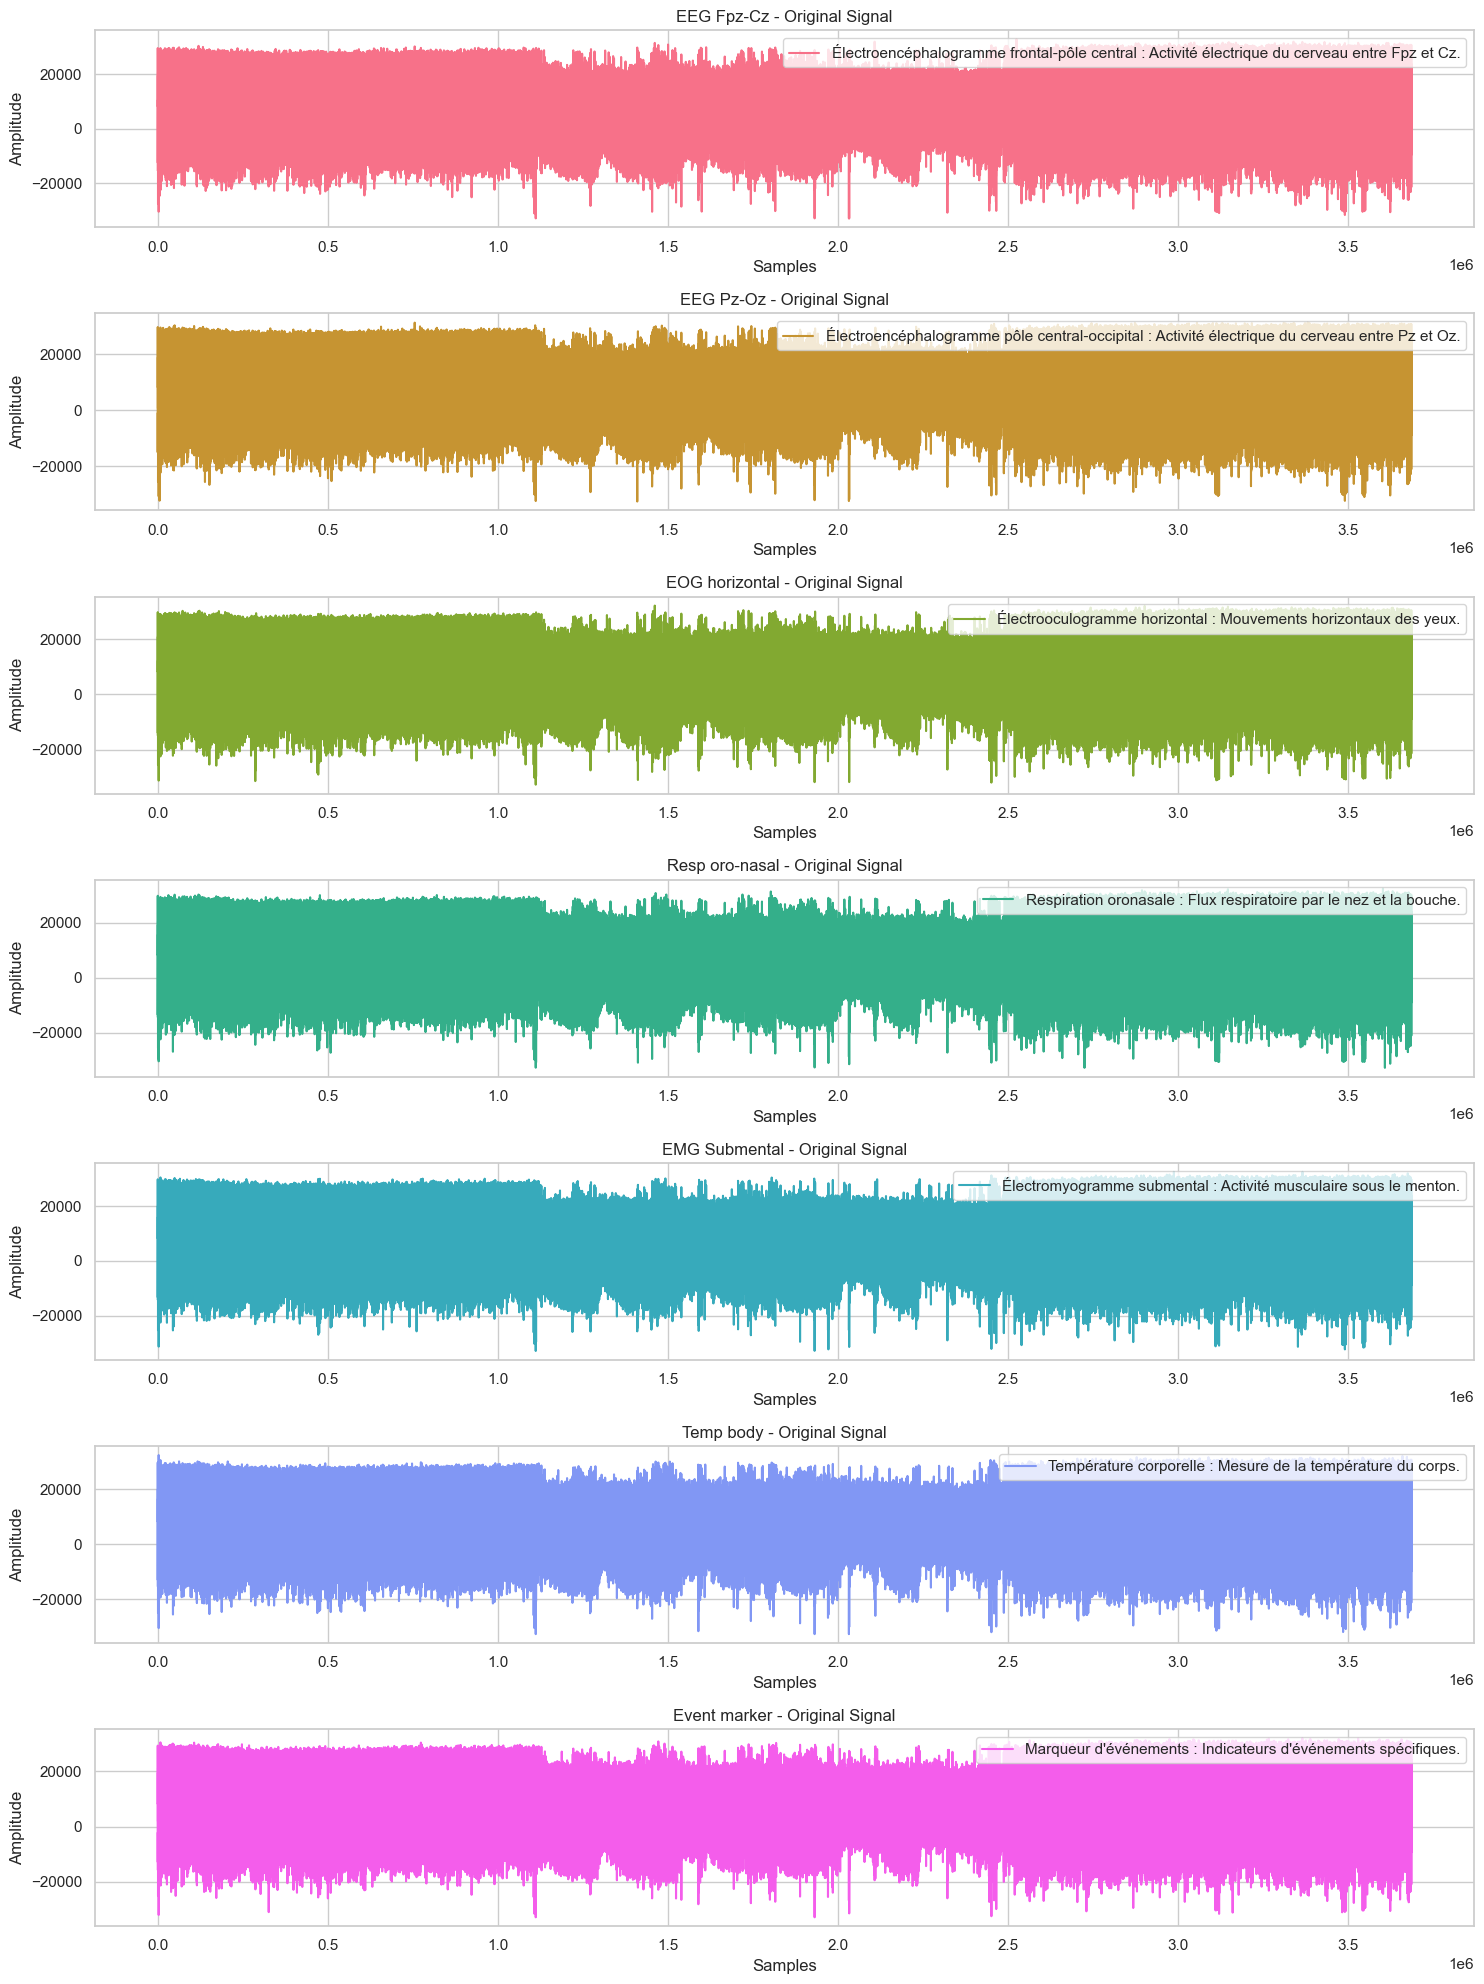

In [3]:
# Apply Seaborn style
sns.set(style="whitegrid")

# Visualize original signals
fig_time, axes_time = plt.subplots(num_channels, 1, figsize=(15, 20))
for i, (channel, description) in enumerate(channel_info.items()):
    axes_time[i].plot(signals[:, i], label=description, color=sns.color_palette("husl", num_channels)[i])
    axes_time[i].set_title(f'{channel} - Original Signal')
    axes_time[i].set_xlabel('Samples')
    axes_time[i].set_ylabel('Amplitude')
    axes_time[i].legend(loc='upper right')
    axes_time[i].grid(True)
fig_time.tight_layout()
fig_time.savefig('original_signals.png')
plt.show()


# Mix Signals and Apply FastICA

In [4]:
# Mix the signals to create observed mixtures using a predefined random mixing matrix
np.random.seed(0)  # For reproducibility
A = np.random.rand(num_channels, num_channels)  # Random mixing matrix
X_mixed = np.dot(A, signals.T).T  # Mixed signals

# Standardize the mixed signals
scaler = StandardScaler()
X_mixed_scaled = scaler.fit_transform(X_mixed)

# Apply FastICA to separate the mixed signals
separated_signals = fastica(X_mixed_scaled, num_components=num_channels)


# Visualize Separated Signals

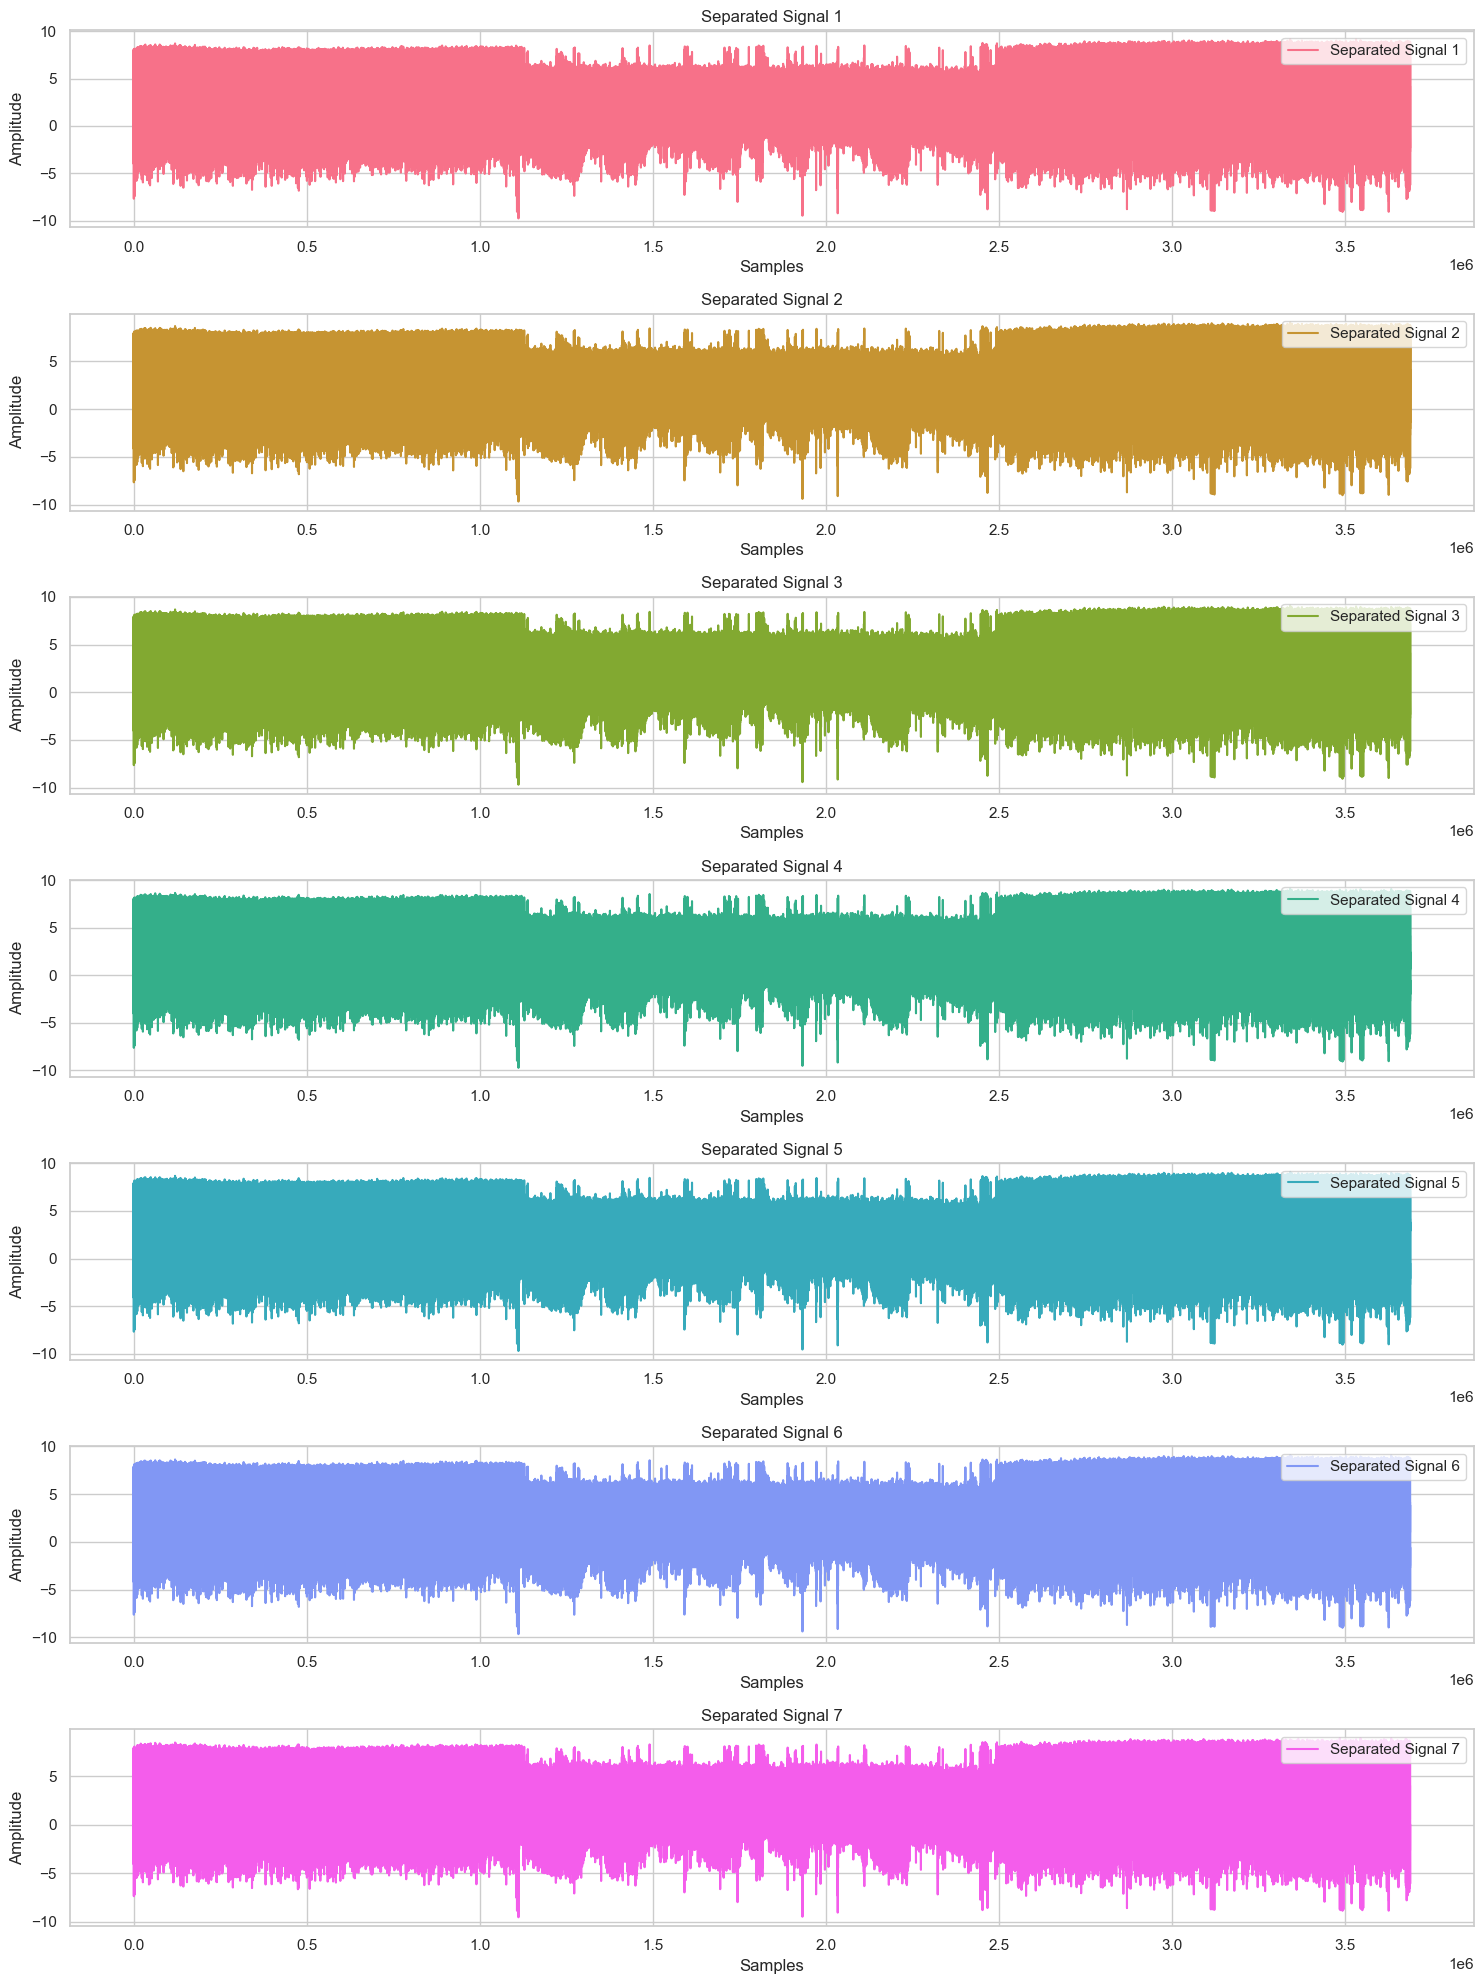

In [5]:
# Visualize the separated signals obtained by FastICA
fig_separated, axes_separated = plt.subplots(num_channels, 1, figsize=(15, 20))
for i in range(num_channels):
    axes_separated[i].plot(separated_signals[:, i], label=f'Separated Signal {i+1}', color=sns.color_palette("husl", num_channels)[i])
    axes_separated[i].set_title(f'Separated Signal {i+1}')
    axes_separated[i].set_xlabel('Samples')
    axes_separated[i].set_ylabel('Amplitude')
    axes_separated[i].legend(loc='upper right')
    axes_separated[i].grid(True)
fig_separated.tight_layout()
fig_separated.savefig('separated_signals.png')
plt.show()



# Compare Original and Separated Signals

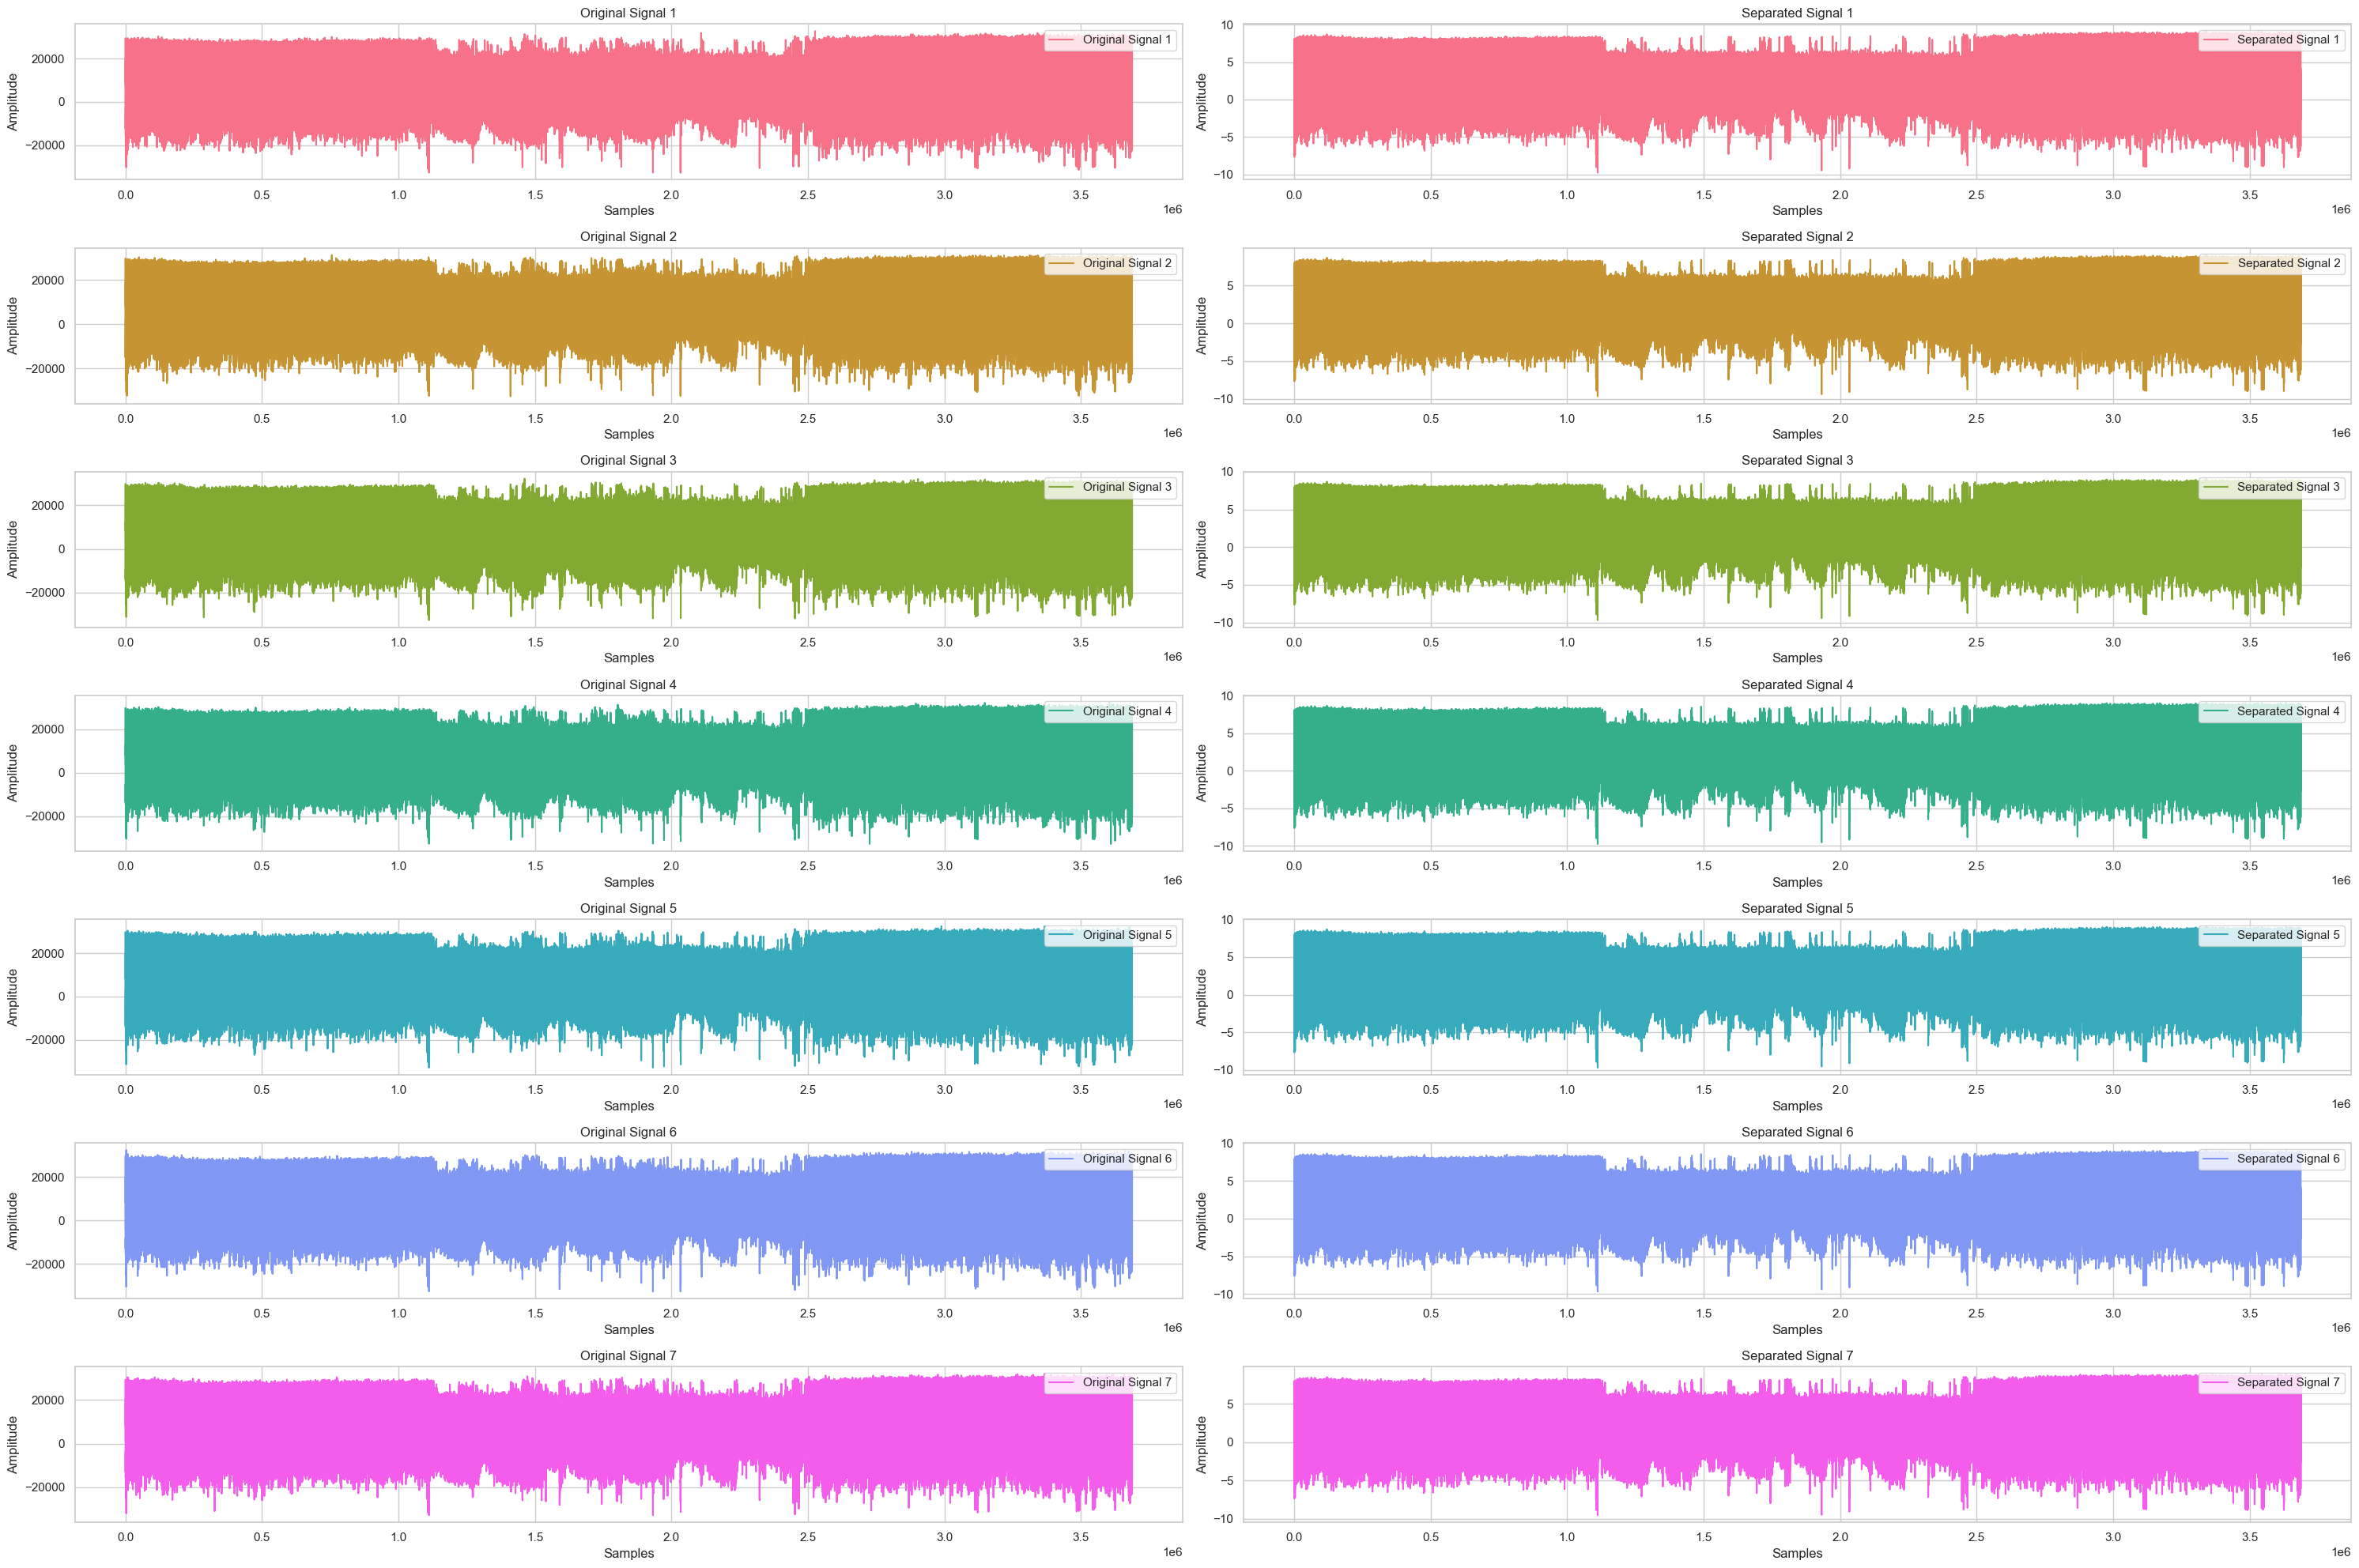

In [6]:
# Compare original and separated signals side by side
fig_compare, axes_compare = plt.subplots(num_channels, 2, figsize=(30, 20))
for i, (channel, description) in enumerate(channel_info.items()):
    # Original signals
    axes_compare[i, 0].plot(signals[:, i], label=f'Original Signal {i+1}', color=sns.color_palette("husl", num_channels)[i])
    axes_compare[i, 0].set_title(f'Original Signal {i+1}')
    axes_compare[i, 0].set_xlabel('Samples')
    axes_compare[i, 0].set_ylabel('Amplitude')
    axes_compare[i, 0].legend(loc='upper right')
    axes_compare[i, 0].grid(True)
    
    # Separated signals
    axes_compare[i, 1].plot(separated_signals[:, i], label=f'Separated Signal {i+1}', color=sns.color_palette("husl", num_channels)[i])
    axes_compare[i, 1].set_title(f'Separated Signal {i+1}')
    axes_compare[i, 1].set_xlabel('Samples')
    axes_compare[i, 1].set_ylabel('Amplitude')
    axes_compare[i, 1].legend(loc='upper right')
    axes_compare[i, 1].grid(True)
fig_compare.tight_layout()
fig_compare.savefig('compare_signals.png')
plt.show()


# Analyze Metrics and Noise Handling

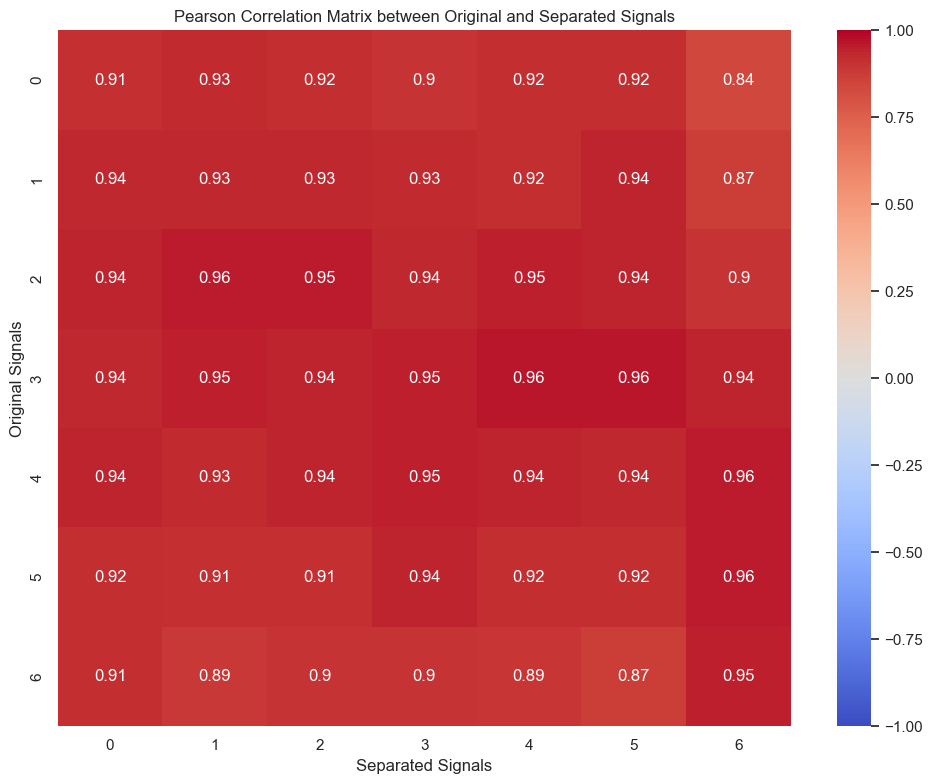

In [7]:
# Calculate simple correlation metrics
correlation_matrix = np.zeros((num_channels, num_channels))

for i in range(num_channels):
    for j in range(num_channels):
        # Calculate Pearson correlation
        correlation_matrix[i, j] = pearsonr(signals[:, i], separated_signals[:, j])[0]

# Display the correlation matrix
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', vmin=-1, vmax=1)
plt.title('Pearson Correlation Matrix between Original and Separated Signals')
plt.xlabel('Separated Signals')
plt.ylabel('Original Signals')
plt.tight_layout()
plt.savefig('correlation_matrix.png')
plt.show()

# Add Gaussian noise to signals
noise_level = 0.1
noisy_signals = signals + noise_level * np.random.normal(size=signals.shape)

# Mix the noisy signals
X_noisy_mixed = np.dot(A, noisy_signals.T).T  # Mixed noisy signals

# Standardize the noisy mixed signals
X_noisy_mixed_scaled = scaler.fit_transform(X_noisy_mixed)

# Apply FastICA to separate noisy mixed signals
separated_noisy_signals = fastica(X_noisy_mixed_scaled, num_components=num_channels)


# Visualize and Analyze Noisy Separated Signals

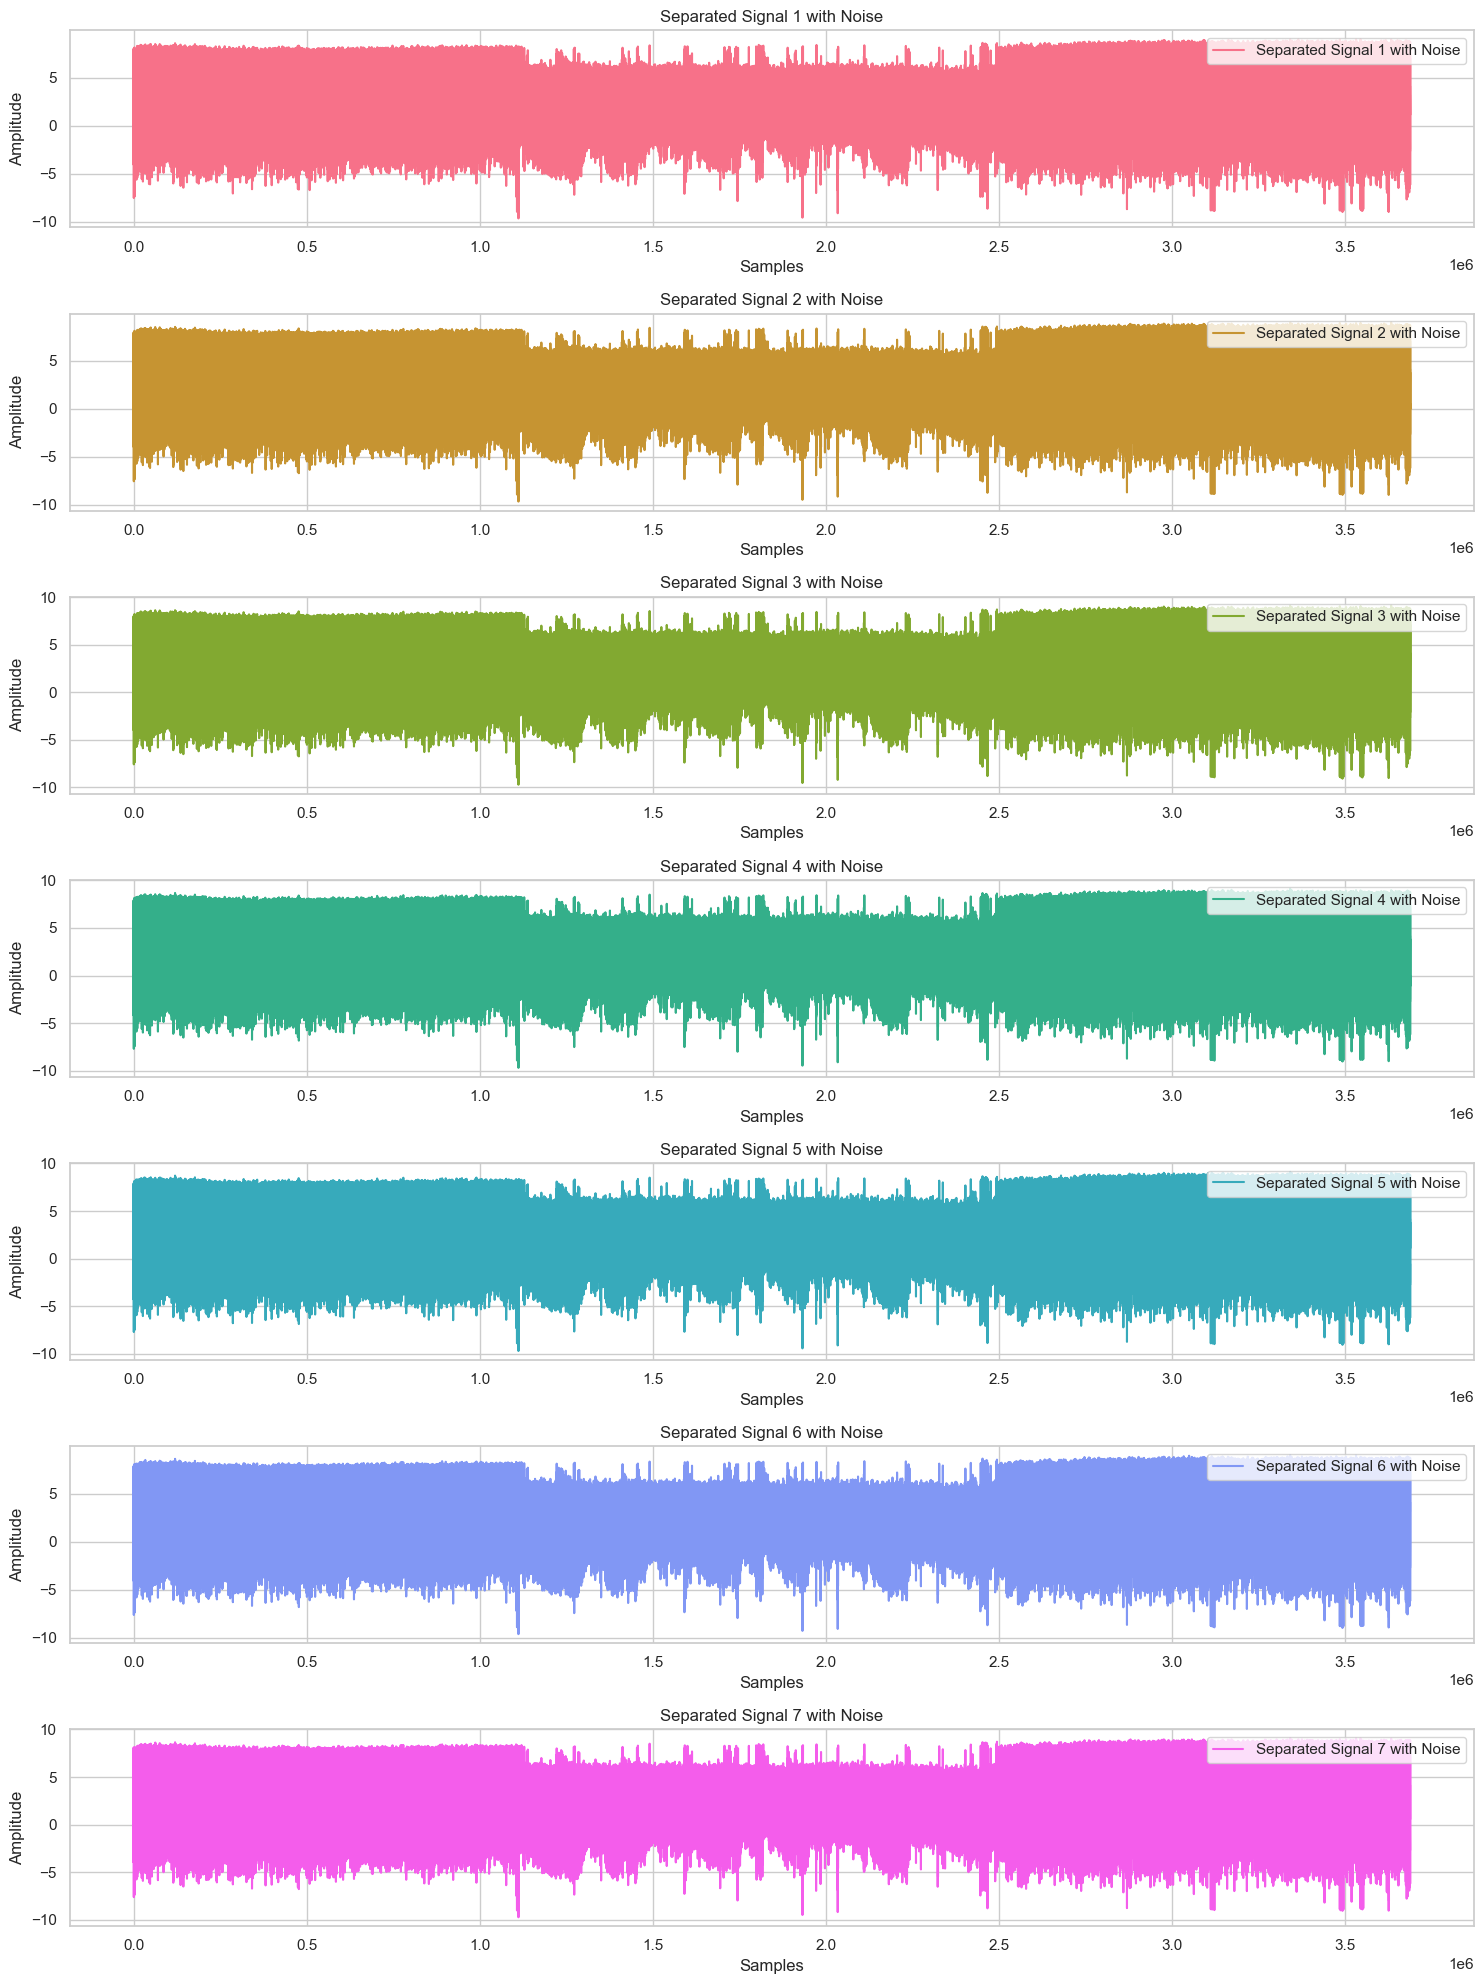

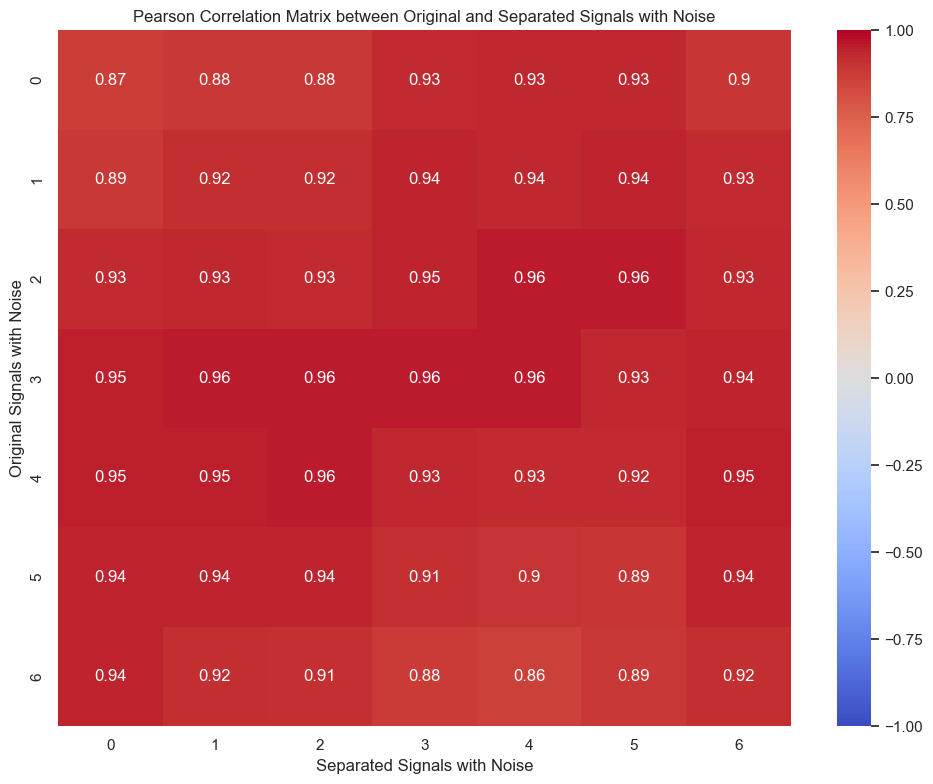

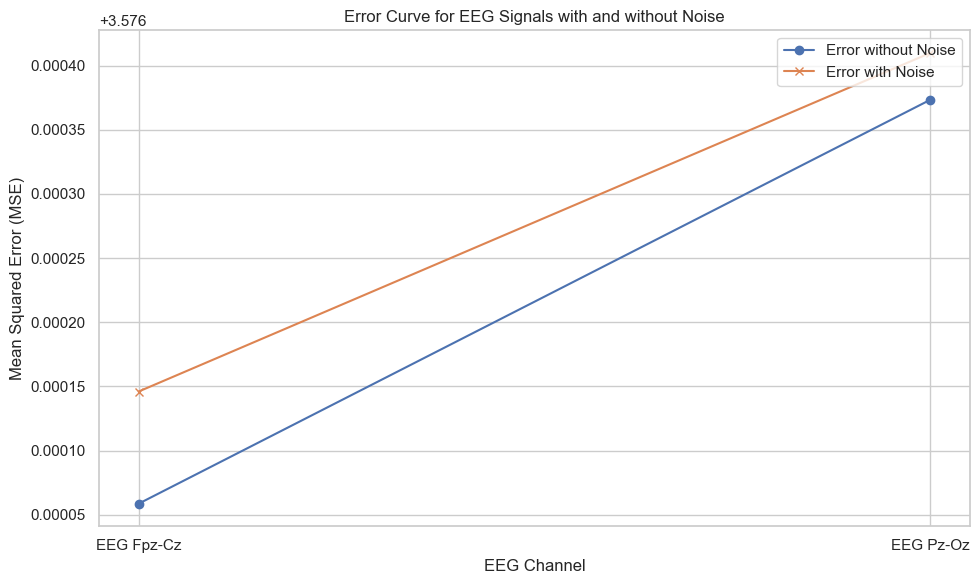

In [8]:
# Visualize the separated signals obtained by FastICA with noise
fig_separated_noisy, axes_separated_noisy = plt.subplots(num_channels, 1, figsize=(15, 20))
for i in range(num_channels):
    axes_separated_noisy[i].plot(separated_noisy_signals[:, i], label=f'Separated Signal {i+1} with Noise', color=sns.color_palette("husl", num_channels)[i])
    axes_separated_noisy[i].set_title(f'Separated Signal {i+1} with Noise')
    axes_separated_noisy[i].set_xlabel('Samples')
    axes_separated_noisy[i].set_ylabel('Amplitude')
    axes_separated_noisy[i].legend(loc='upper right')
    axes_separated_noisy[i].grid(True)
fig_separated_noisy.tight_layout()
fig_separated_noisy.savefig('separated_signals_noise.png')
plt.show()

# Calculate simple correlation metrics with noise
correlation_matrix_noisy = np.zeros((num_channels, num_channels))

for i in range(num_channels):
    for j in range(num_channels):
        # Calculate Pearson correlation
        correlation_matrix_noisy[i, j] = pearsonr(noisy_signals[:, i], separated_noisy_signals[:, j])[0]

# Display the correlation matrix with noise
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix_noisy, annot=True, cmap='coolwarm', vmin=-1, vmax=1)
plt.title('Pearson Correlation Matrix between Original and Separated Signals with Noise')
plt.xlabel('Separated Signals with Noise')
plt.ylabel('Original Signals with Noise')
plt.tight_layout()
plt.savefig('correlation_matrix_noise.png')
plt.show()

# Select the indices of EEG channels
eeg_indices = [0, 1]  # Indices of 'EEG Fpz-Cz' and 'EEG Pz-Oz' signals

# Calculate and display the error curve for EEG signals only
error_without_noise = np.mean((signals[:, eeg_indices] - separated_signals[:, eeg_indices]) ** 2, axis=0) / total_samples
error_with_noise = np.mean((noisy_signals[:, eeg_indices] - separated_noisy_signals[:, eeg_indices]) ** 2, axis=0) / total_samples

plt.figure(figsize=(10, 6))
plt.plot(eeg_indices, error_without_noise, label='Error without Noise', marker='o')
plt.plot(eeg_indices, error_with_noise, label='Error with Noise', marker='x')
plt.xticks(ticks=eeg_indices, labels=['EEG Fpz-Cz', 'EEG Pz-Oz'])
plt.title('Error Curve for EEG Signals with and without Noise')
plt.xlabel('EEG Channel')
plt.ylabel('Mean Squared Error (MSE)')
plt.legend(loc='upper right')
plt.grid(True)
plt.tight_layout()
plt.savefig('eeg_error_curve.png')
plt.show()
